In [1]:
import pandas as pd
import sklearn
import numpy as np

credit=pd.read_csv("Credit_default_dataset.csv")
credit.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [2]:
#We don't need the ID column,so lets drop it.
credit = credit.drop(["ID"],axis=1)

In [3]:
#changing the name of  pay_0 column to pay_1 to make the numbering correct

In [4]:
credit.rename(columns={'PAY_0':'PAY_1'}, inplace=True)

In [5]:
credit.head(1)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1


In [6]:
#Removing Unwanted categorical levels as mentioned in data exploration
credit['EDUCATION'].value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

In [7]:
#Changing Education levels 0,5,6 to others(4)
credit["EDUCATION"]=credit["EDUCATION"].map({0:4,1:1,2:2,3:3,4:4,5:4,6:4})

In [8]:
credit['EDUCATION'].value_counts()

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

In [9]:
credit['MARRIAGE'].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

In [10]:
#similarly chaning marriage level 0 to level 3
credit["MARRIAGE"]=credit["MARRIAGE"].map({0:3,1:1,2:2,3:3})

In [11]:
credit['MARRIAGE'].value_counts()

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

### feature engineering 

In [12]:
from itertools import groupby


In [ ]:
# 1. Credit Utilization Ratio
credit['CUR'] = credit['BILL_AMT6'] / credit['LIMIT_BAL']

# 2. Repayment Ratios (for each billing cycle)
for i in range(1, 7):
    credit[f'PAY_RATIO{i}'] = credit[f'PAY_AMT{i}'] / (credit[f'BILL_AMT{i}'] + 0.001)  # Avoid division by zero

# 3. Total & Average Bill Amounts
credit['TOTAL_BILL'] = credit[[f'BILL_AMT{i}' for i in range(1, 7)]].sum(axis=1)
credit['AVG_BILL'] = credit['TOTAL_BILL'] / 6

# 4. Total & Average Payments
credit['TOTAL_PAY'] = credit[[f'PAY_AMT{i}' for i in range(1, 7)]].sum(axis=1)
credit['AVG_PAY'] = credit['TOTAL_PAY'] / 6

# 5. Payment Volatility (Standard Deviation)
credit['PAY_STD'] = credit[[f'PAY_AMT{i}' for i in range(1, 7)]].std(axis=1)

# 6. Number of Late Payments (PAY_X > 0)
credit['LATE_PAYS'] = (credit[[f'PAY_{i}' for i in range(1, 7)]].gt(0)).sum(axis=1)

# 7. Maximum Late Payment
credit['MAX_LATE'] = credit[[f'PAY_{i}' for i in range(1, 7)]].max(axis=1)

# 8. Recent Late Payments (Sum of last 3 months)
credit['RECENT_LATE'] = credit['PAY_1'] + credit['PAY_2'] + credit['PAY_3']

# # 9. Consecutive Late Payments
# credit['CONSEC_LATE'] = credit.apply(lambda row: max(len(list(g)) for k, g in 
#                              groupby(row[[f'PAY_{i}' for i in range(1, 7)]].gt(0)) if k), axis=1)

# 10. Interaction Features
credit['LIMIT_AGE_RATIO'] = credit['LIMIT_BAL'] / (credit['AGE'] + 1)  # Avoid division by zero
credit['AVG_PAY_TO_LIMIT'] = credit['AVG_PAY'] / (credit['LIMIT_BAL'] + 1)


In [14]:
credit.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.842267,0.744494,1.0,1.00,2.0,2.00,4.0
MARRIAGE,30000.0,1.557267,0.521405,1.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


                            LIMIT_BAL       SEX  EDUCATION  MARRIAGE  \
LIMIT_BAL                    1.000000  0.024755  -0.231088 -0.111012   
SEX                          0.024755  1.000000   0.013627 -0.028522   
EDUCATION                   -0.231088  0.013627   1.000000 -0.136797   
MARRIAGE                    -0.111012 -0.028522  -0.136797  1.000000   
AGE                          0.144713 -0.090874   0.182434 -0.412001   
PAY_1                       -0.271214 -0.057643   0.112593  0.018557   
PAY_2                       -0.296382 -0.070771   0.129703  0.023620   
PAY_3                       -0.286123 -0.066096   0.122425  0.032399   
PAY_4                       -0.267460 -0.060173   0.116531  0.031831   
PAY_5                       -0.249411 -0.055064   0.104088  0.034377   
PAY_6                       -0.235195 -0.044008   0.088986  0.033168   
BILL_AMT1                    0.285430 -0.033642   0.016597 -0.027832   
BILL_AMT2                    0.278314 -0.031183   0.011980 -0.02

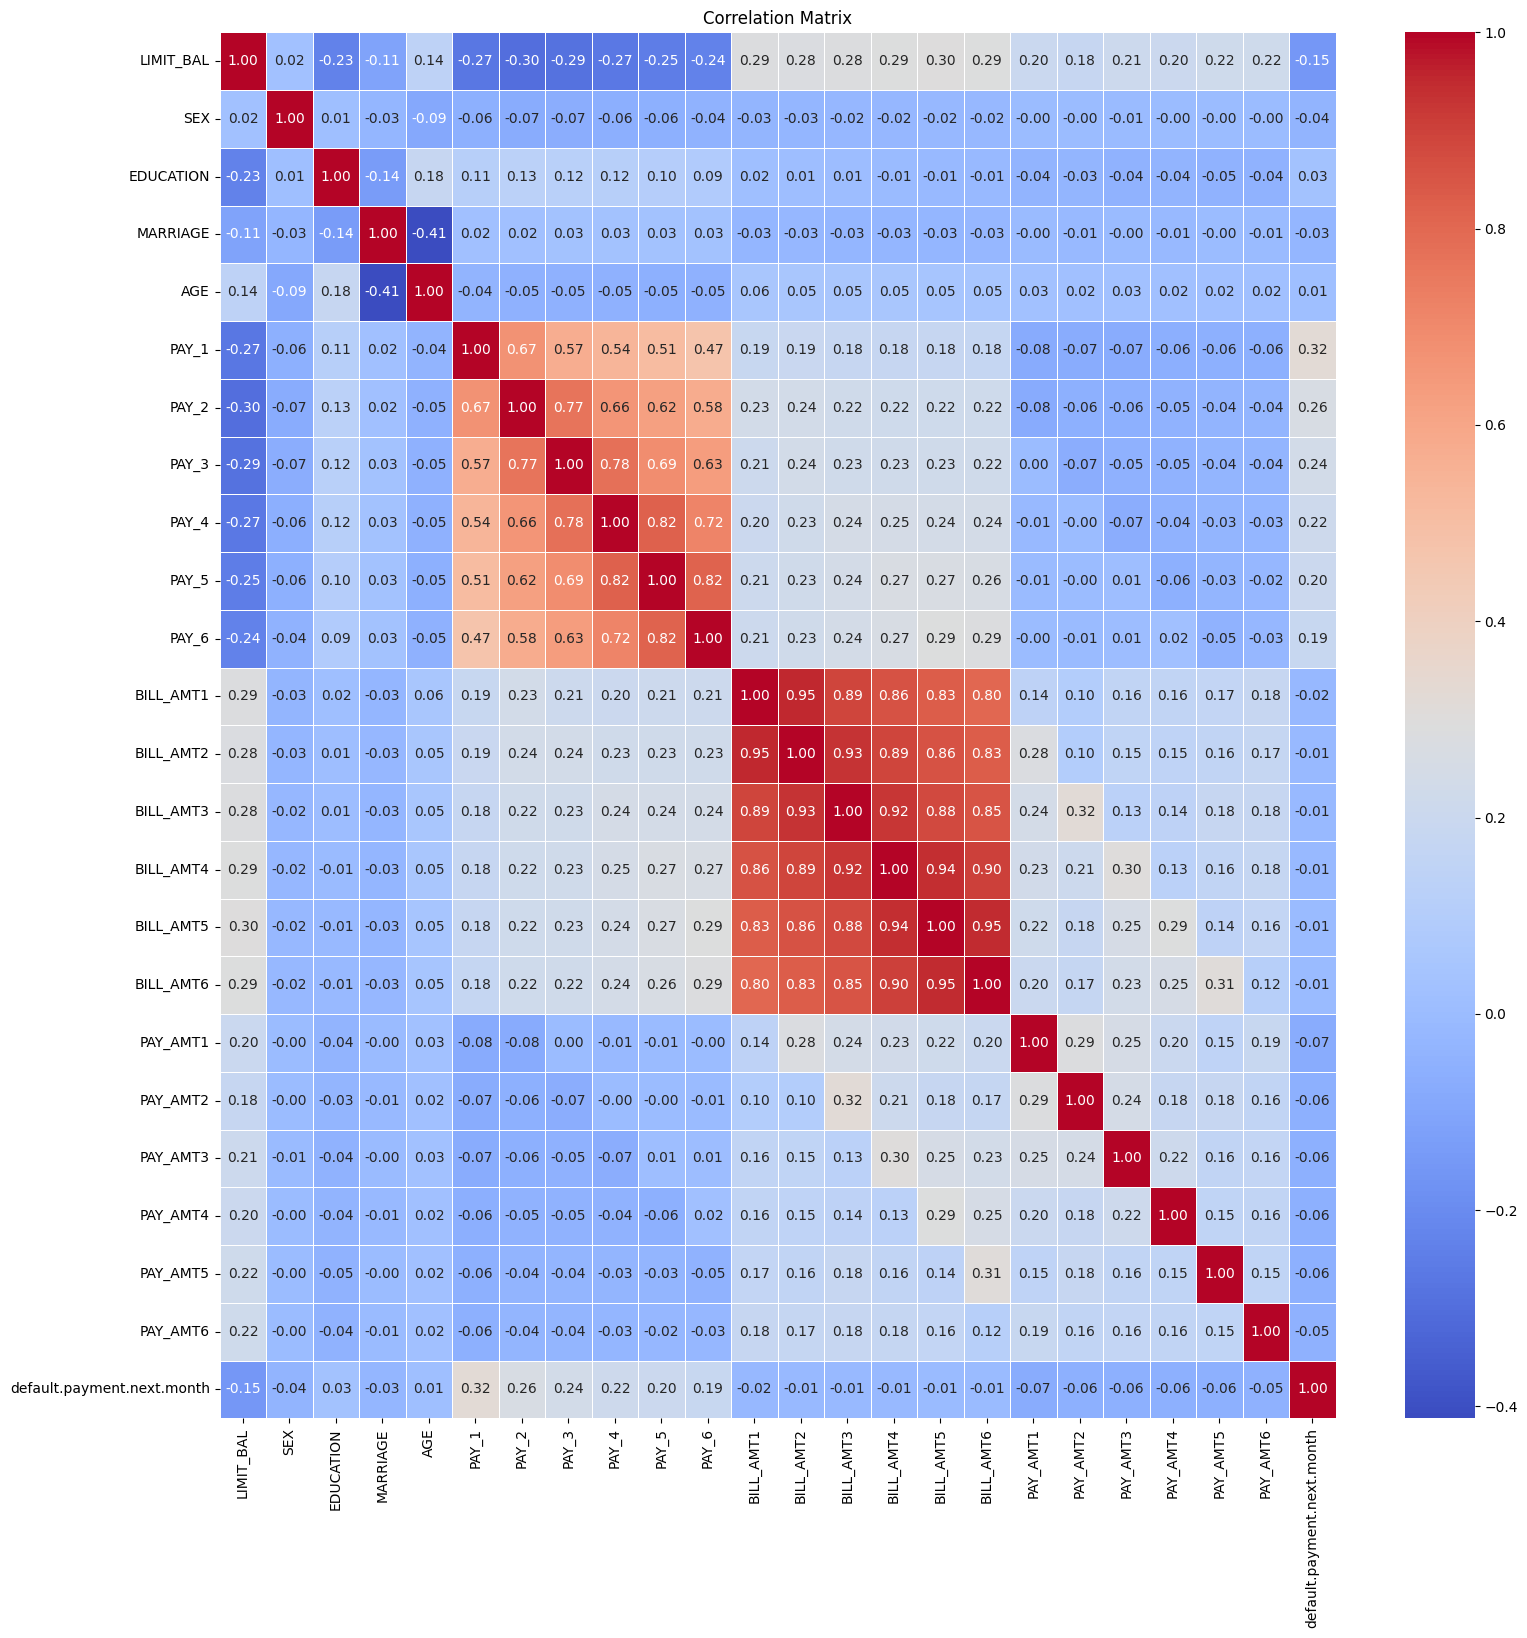

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = credit.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize with a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


In [16]:
corr_matrix = credit.corr().abs()

# Set a correlation threshold (e.g., 0.85)
threshold = 0.85

# Find highly correlated columns
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop the highly correlated columns
credit = credit.drop(columns=to_drop)

In [17]:
#lets check which features are important
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
X = credit.drop('default.payment.next.month',axis=1)
Y = credit['default.payment.next.month']
clf = ExtraTreesClassifier()
clf = clf.fit(X, Y)
feature_importances = clf.feature_importances_
feature_importances

array([0.08524506, 0.01304645, 0.03384208, 0.02166447, 0.08942272,
       0.10163893, 0.05375413, 0.034669  , 0.03203031, 0.0306165 ,
       0.03420843, 0.08043741, 0.06566207, 0.06431524, 0.06413113,
       0.06249143, 0.06512777, 0.06769685])

In [ ]:
feature_importance_pairs = list(zip(X.columns, feature_importances))

# Sort features by importance (descending order)
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Calculate cumulative importance
cumulative_importance = np.cumsum([importance for _, importance in sorted_feature_importance_pairs])

# Select features that contribute to 90% cumulative importance
selected_features = [name for name, importance in sorted_feature_importance_pairs[:np.argmax(cumulative_importance >= 0.4) + 1]]

# Print the selected features with their importance values
print("Selected features (cumulative importance 0.9):")
for name, importance in sorted_feature_importance_pairs:
    if name in selected_features:
        print(f"{name}: {importance:.6f}")

selected_features.append("default.payment.next.month")
credit = credit[selected_features]

                            LIMIT_BAL       SEX  EDUCATION  MARRIAGE  \
LIMIT_BAL                    1.000000  0.024755  -0.231088 -0.111012   
SEX                          0.024755  1.000000   0.013627 -0.028522   
EDUCATION                   -0.231088  0.013627   1.000000 -0.136797   
MARRIAGE                    -0.111012 -0.028522  -0.136797  1.000000   
AGE                          0.144713 -0.090874   0.182434 -0.412001   
PAY_1                       -0.271214 -0.057643   0.112593  0.018557   
PAY_2                       -0.296382 -0.070771   0.129703  0.023620   
PAY_3                       -0.286123 -0.066096   0.122425  0.032399   
PAY_4                       -0.267460 -0.060173   0.116531  0.031831   
PAY_5                       -0.249411 -0.055064   0.104088  0.034377   
PAY_6                       -0.235195 -0.044008   0.088986  0.033168   
BILL_AMT1                    0.285430 -0.033642   0.016597 -0.027832   
PAY_AMT1                     0.195236 -0.000242  -0.041088 -0.00

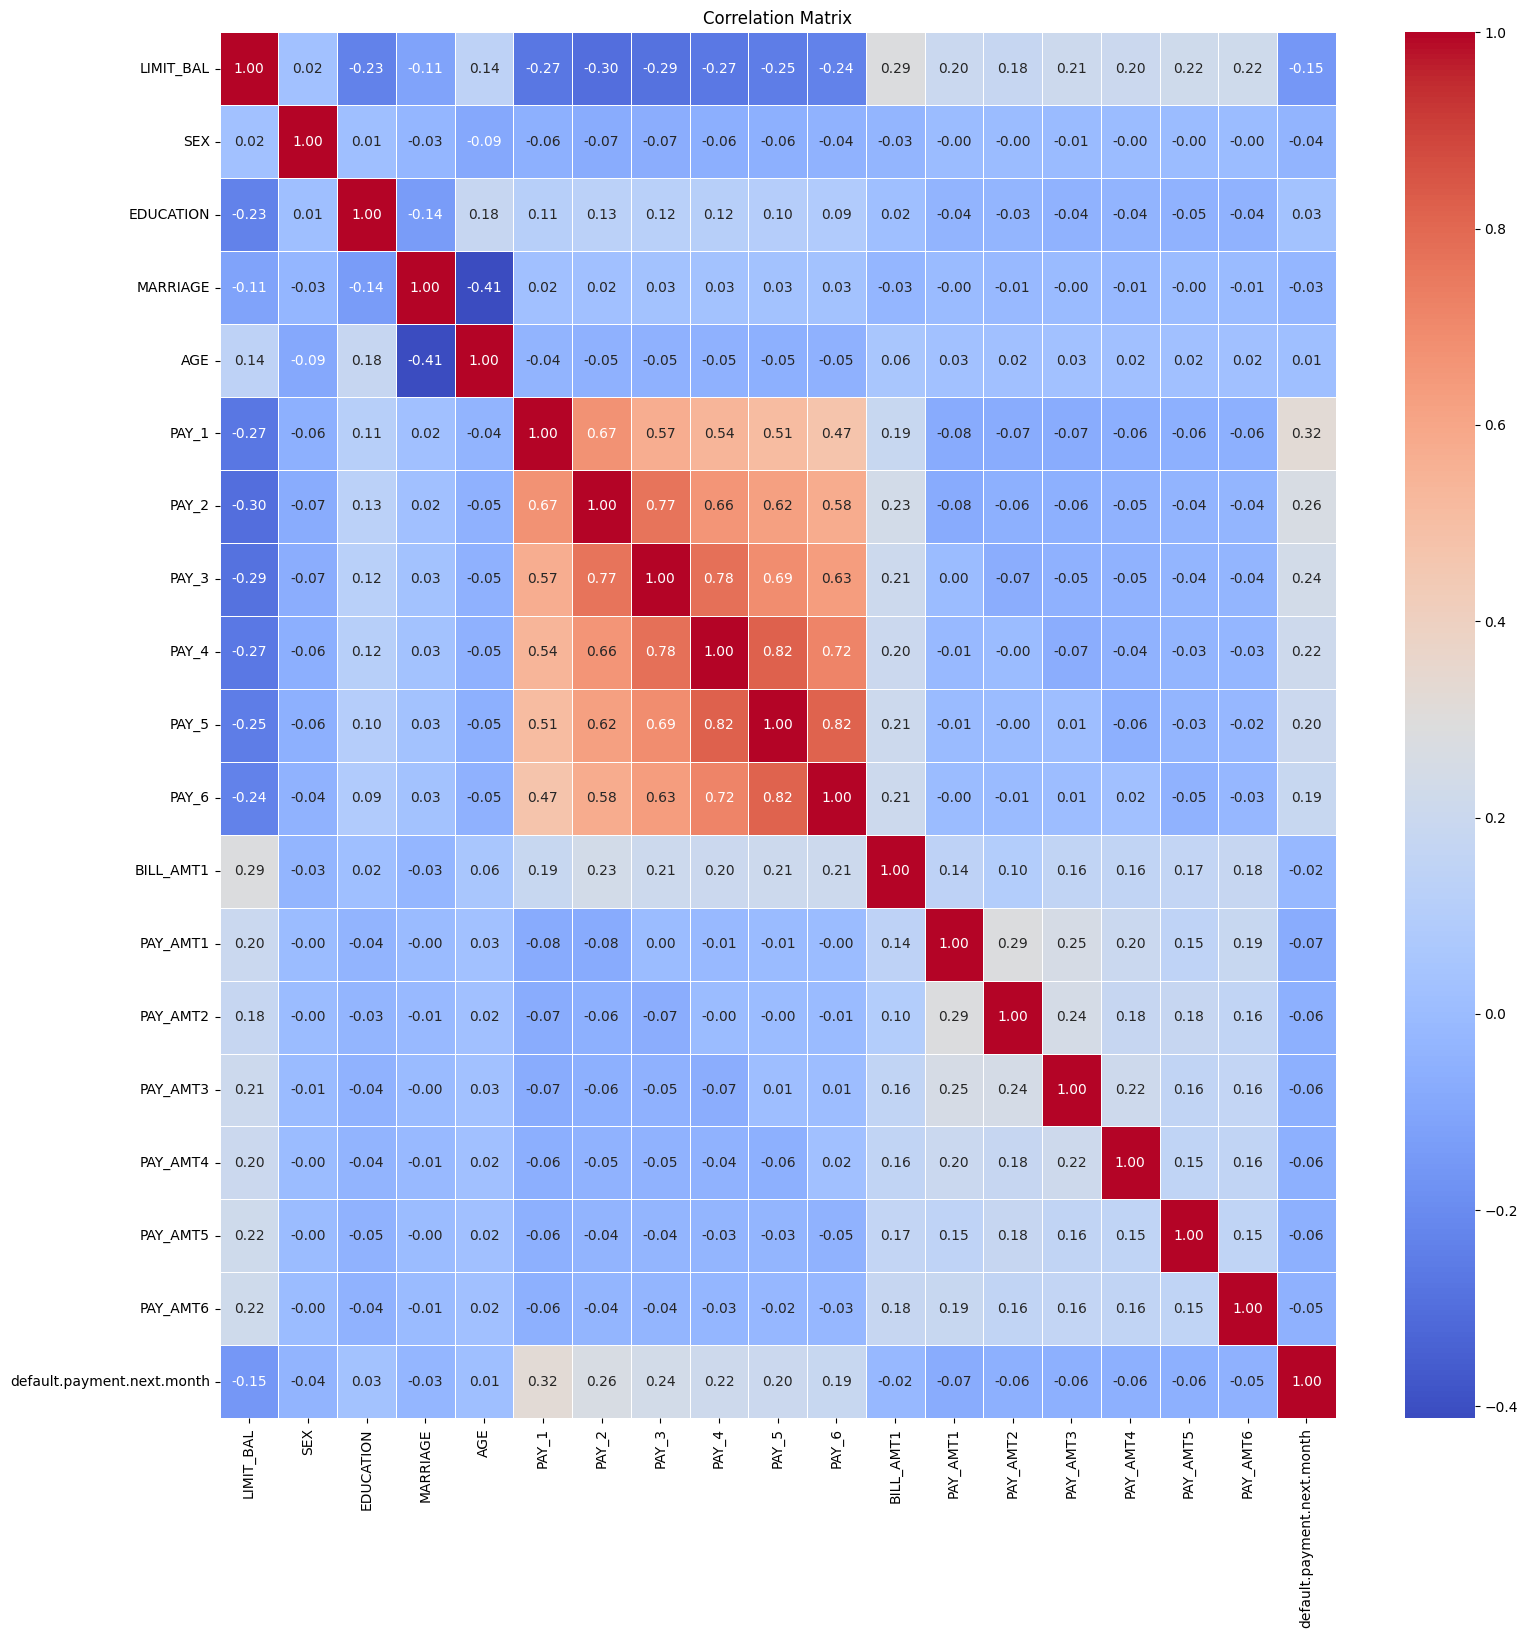

In [19]:
# Compute correlation matrix
corr_matrix = credit.corr()

# Display the correlation matrix
print(corr_matrix)

# Visualize with a heatmap
plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [20]:
%matplotlib inline
#feature scaling check
# credit['BILL_AMT1'].hist(bins=60, color='orange')

In [21]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit_transform(credit)

array([[0.01010101, 1.        , 0.33333333, ..., 0.        , 0.        ,
        1.        ],
       [0.11111111, 1.        , 0.33333333, ..., 0.        , 0.00378311,
        1.        ],
       [0.08080808, 1.        , 0.33333333, ..., 0.00234451, 0.00945777,
        0.        ],
       ...,
       [0.02020202, 0.        , 0.33333333, ..., 0.00468901, 0.00586382,
        1.        ],
       [0.07070707, 0.        , 0.66666667, ..., 0.12417444, 0.00341236,
        1.        ],
       [0.04040404, 0.        , 0.33333333, ..., 0.00234451, 0.00189155,
        1.        ]])

In [22]:
#check for null values
credit.apply(lambda x: sum(x.isnull()),axis=0) 

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [23]:
#Initial Model training(except feed forward neural network)
from sklearn.model_selection import train_test_split

train, test = train_test_split(credit, test_size = 0.85)

X_train = train.drop('default.payment.next.month',axis=1)

y_train = train['default.payment.next.month']

X_test =  test.drop('default.payment.next.month',axis=1)

y_test = test['default.payment.next.month']

In [24]:
#Train benchmark model(Log Regression)
from sklearn.linear_model import LogisticRegression
clf0 = LogisticRegression(random_state=10)
clf0.fit(X_train, y_train)

c:\Users\twidanagamage\Desktop\Credit Risk Classification\Credit-Risk-Modeling-using-Machine-Learning\pm\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=10)

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
y_pred = clf0.predict(X_test)
accuracy_regr=accuracy_score(y_test, y_pred)
precision_regr=precision_score(y_test, y_pred,average='weighted')
recall_regr=recall_score(y_test, y_pred,average='weighted')
f1_regr=f1_score(y_test,y_pred,average='weighted')
print("accuracy:", accuracy_regr)
print("Precision:", precision_regr)
print("Recall:", recall_regr)
print('f1_score:',f1_regr)

accuracy: 0.779607843137255
Precision: 0.6077883890811226
Recall: 0.779607843137255
f1_score: 0.6830587889629187


c:\Users\twidanagamage\Desktop\Credit Risk Classification\Credit-Risk-Modeling-using-Machine-Learning\pm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
#Train other classifiers
#We start with randomforest
from sklearn.ensemble import RandomForestClassifier
clf1=RandomForestClassifier(warm_start=True, random_state=10)
clf1.fit(X_train,y_train)

RandomForestClassifier(random_state=10, warm_start=True)

In [27]:
y_pred1 = clf1.predict(X_test)
accuracy_rf=accuracy_score(y_test, y_pred1)
precision_rf=precision_score(y_test, y_pred1,average='weighted')
recall_rf=recall_score(y_test, y_pred1,average='weighted')
f1_rf=f1_score(y_test,y_pred1,average='weighted')
print("accuracy:", accuracy_rf)
print("Precision:", precision_rf)
print("Recall:", recall_rf)
print('f1_score:',f1_rf)

accuracy: 0.8115294117647058
Precision: 0.7915554815646254
Recall: 0.8115294117647058
f1_score: 0.7911949854748049


In [28]:
#gradeint boost
from sklearn.ensemble import GradientBoostingClassifier
clf2=GradientBoostingClassifier(random_state=10)
clf2.fit(X_train,y_train)

GradientBoostingClassifier(random_state=10)

In [29]:
y_pred2 = clf2.predict(X_test)
accuracy_gb=accuracy_score(y_test, y_pred2)
precision_gb=precision_score(y_test, y_pred2,average='weighted')
recall_gb=recall_score(y_test, y_pred2,average='weighted')
f1_gb=f1_score(y_test,y_pred2,average='weighted')
print("accuracy:", accuracy_gb)
print("Precision:", precision_gb)
print("Recall:", recall_gb)
print('f1_score:',f1_gb)

accuracy: 0.818078431372549
Precision: 0.8000932743722063
Recall: 0.818078431372549
f1_score: 0.7971788205989717


In [30]:
#adaboost
from sklearn.ensemble import AdaBoostClassifier
clf3 = AdaBoostClassifier(random_state=10)
clf3.fit(X_train, y_train)

AdaBoostClassifier(random_state=10)

In [31]:
y_pred3 = clf3.predict(X_test)
accuracy_ab=accuracy_score(y_test, y_pred3)
precision_ab=precision_score(y_test, y_pred3,average='weighted')
recall_ab=recall_score(y_test, y_pred3,average='weighted')
f1_ab=f1_score(y_test,y_pred3,average='weighted')
print("accuracy:", accuracy_ab)
print("Precision:", precision_ab)
print("Recall:", recall_ab)
print('f1_score:',f1_ab)

accuracy: 0.8170196078431372
Precision: 0.7997357784758186
Recall: 0.8170196078431372
f1_score: 0.7889294565975519


In [32]:
#voting classifier
from sklearn.ensemble import VotingClassifier
clf4 = VotingClassifier(estimators=[('rf',clf1),('gb', clf2),('ab',clf3)])
clf4.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(random_state=10,
                                                     warm_start=True)),
                             ('gb',
                              GradientBoostingClassifier(random_state=10)),
                             ('ab', AdaBoostClassifier(random_state=10))])

In [33]:
y_pred4 = clf4.predict(X_test)
accuracy_vc=accuracy_score(y_test, y_pred4)
precision_vc=precision_score(y_test, y_pred4,average='weighted')
recall_vc=recall_score(y_test, y_pred4,average='weighted')
f1_vc=f1_score(y_test,y_pred4,average='weighted')
print("accuracy:", accuracy_vc)
print("Precision:", precision_vc)
print("Recall:", recall_vc)
print('f1_score:',f1_vc)

accuracy: 0.8187450980392157
Precision: 0.8011574645128999
Recall: 0.8187450980392157
f1_score: 0.7951311126378168


In [34]:
#appending all socres
arraycuracy=[]
arraycuracy.append(accuracy_regr)
arraycuracy.append(accuracy_rf)
arraycuracy.append(accuracy_gb)
arraycuracy.append(accuracy_ab)
arraycuracy.append(accuracy_vc)

In [35]:
precisionray=[]
precisionray.append(precision_regr)
precisionray.append(precision_rf)
precisionray.append(precision_gb)
precisionray.append(precision_ab)
precisionray.append(precision_vc)

In [36]:
recallray=[]
recallray.append(recall_regr)
recallray.append(recall_rf)
recallray.append(recall_gb)
recallray.append(recall_ab)
recallray.append(recall_vc)

In [37]:
f1ray=[]
f1ray.append(f1_regr)
f1ray.append(f1_rf)
f1ray.append(f1_gb)
f1ray.append(f1_ab)
f1ray.append(f1_vc)

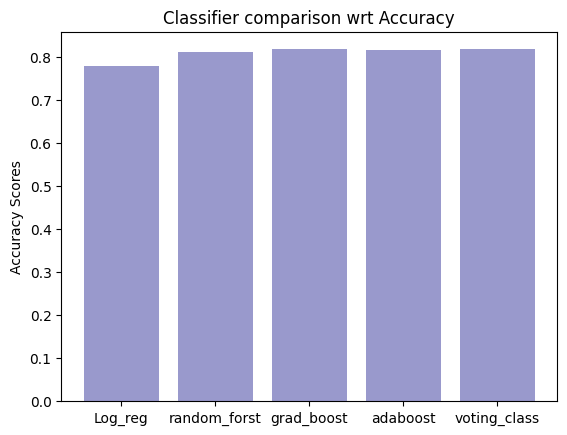

In [38]:
#Lets compare Accuracy,precison,racall
import matplotlib.pyplot as plt
classifier_names=('Log_reg','random_forst','grad_boost','adaboost','voting_class')
y_axis=np.arange(len(classifier_names))
plt.bar(y_axis, arraycuracy, alpha=0.4,color='navy',ecolor='navy')
plt.xticks(y_axis, classifier_names)
plt.ylabel('Accuracy Scores')
plt.title('Classifier comparison wrt Accuracy')
plt.show()

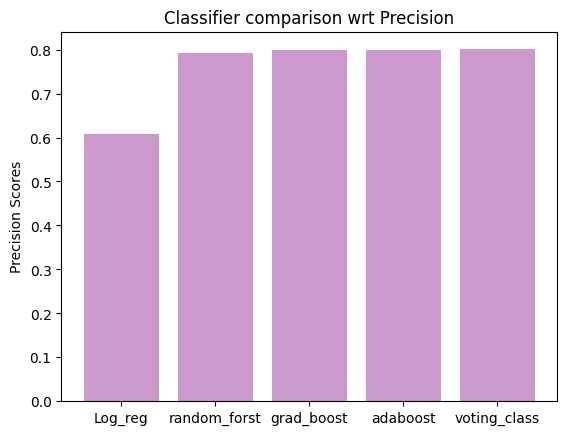

In [39]:
y_axis=np.arange(len(classifier_names))
plt.bar(y_axis,precisionray, alpha=0.4,color='purple',ecolor='darkgreen')
plt.xticks(y_axis, classifier_names)
plt.ylabel('Precision Scores')
plt.title('Classifier comparison wrt Precision')
plt.show()

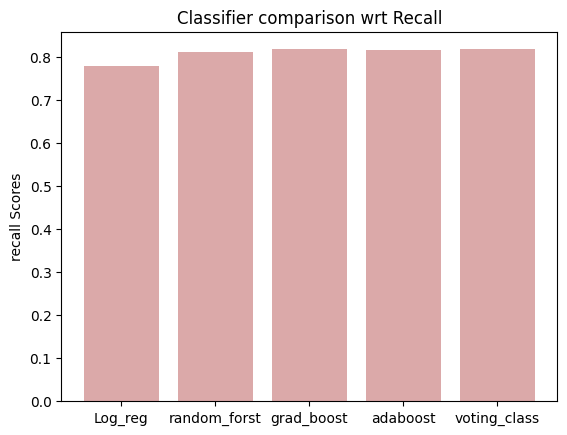

In [40]:
y_axis=np.arange(len(classifier_names))
plt.bar(y_axis,recallray, alpha=0.4,color='brown',ecolor='black')
plt.xticks(y_axis, classifier_names)
plt.ylabel('recall Scores')
plt.title('Classifier comparison wrt Recall')
plt.show()

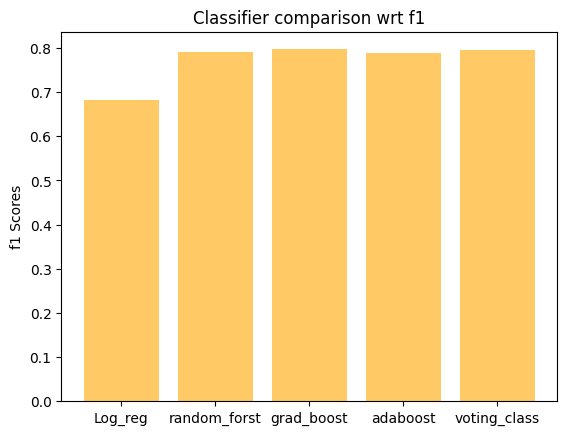

In [41]:
y_axis=np.arange(len(classifier_names))
plt.bar(y_axis,f1ray, alpha=0.6,color='orange',ecolor='black')
plt.xticks(y_axis, classifier_names)
plt.ylabel('f1 Scores')
plt.title('Classifier comparison wrt f1')
plt.show()

In [42]:
#Some fine REFINEMENTS to GBboost,Rfforest,and Adaboost
#PERFROM GRIDSEARCH CV on RF,GB and Adaboost to find best parameter values on 10 fold cross validation set
from sklearn.metrics import classification_report
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


parameters_ada ={'n_estimators' :[15,25,50],
            }



clf = GridSearchCV(AdaBoostClassifier(random_state=10), parameters_ada,cv=10,scoring='accuracy')
clf.fit(X_train, y_train)
print("Best parameters for Adaboost:",clf.best_params_)

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [ ]:
parameters_boost ={'n_estimators' :[15,25,50],
             'min_samples_split' :[3,10,15]
}

clf00 = GridSearchCV(GradientBoostingClassifier(random_state=10), cv=10, param_grid=parameters_boost, scoring='accuracy')
clf00.fit(X_train,y_train)
print("Best parameters for GradeintBoosting:",clf00.best_params_)


clf001 = GridSearchCV(RandomForestClassifier(random_state=10), cv=10, param_grid=parameters_boost,scoring='accuracy')
clf001.fit(X_train,y_train)
print("Best parameters for RandomForest:",clf001.best_params_)

Best parameters for GradeintBoosting: {'min_samples_split': 15, 'n_estimators': 50}
Best parameters for RandomForest: {'min_samples_split': 15, 'n_estimators': 50}


In [ ]:
#Use the above parameter values for our Weighted voting CLassifier

#First we have to calibrate our classsifers

#Isotonic claibration
from sklearn.calibration import CalibratedClassifierCV
clfvc1 = RandomForestClassifier(n_estimators=50,min_samples_split=15,random_state=10)
clfvc2=AdaBoostClassifier(n_estimators=15,random_state=10)
clfvc3=GradientBoostingClassifier(n_estimators=50,min_samples_split=15,random_state=10)
clf_isotonic1 = CalibratedClassifierCV(clfvc1, method='isotonic',cv=10)
clf_isotonic2 = CalibratedClassifierCV(clfvc2, method='isotonic',cv=10)
clf_isotonic3 = CalibratedClassifierCV(clfvc3, method='isotonic',cv=10)

In [ ]:
#Inputing the istonic calibration to voting classifier with weights.
import time
t0 = time.clock()
clfvc = VotingClassifier(estimators=[('rf',clf_isotonic1),('ab', clf_isotonic2),('gb',clf_isotonic3)],voting='soft',weights=[1,1,2])
clfvc.fit(X_train,y_train)

VotingClassifier(estimators=[('rf', CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, m..., subsample=1.0, verbose=0,
              warm_start=False),
            cv=10, method='isotonic'))],
         flatten_transform=None, n_jobs=1, voting='soft',
         weights=[1, 1, 1])

In [ ]:
y_predvc = clfvc.predict(X_test)
accuracy_vciso=accuracy_score(y_test, y_predvc)

In [ ]:
precision_vciso=precision_score(y_test, y_predvc)

In [ ]:
#Results of weighted voting classifer
y_predvc = clfvc.predict(X_test)
accuracy_vciso=accuracy_score(y_test, y_predvc)
precision_vciso=precision_score(y_test, y_predvc,average='weighted')
recall_vciso=recall_score(y_test, y_predvc,average='weighted')
f1_vciso=f1_score(y_test,y_predvc,average='weighted')
print("accuracy:", accuracy_vciso)
print("Precision:", precision_vciso)
print("Recall:", recall_vciso)
print('f1_score:',f1_vciso)
print('Training_time:',time.clock() - t0)

accuracy: 0.821666666667
Precision: 0.805790548828
Recall: 0.821666666667
f1_score: 0.800497169577
Training_time: 59.46775733333334


In [ ]:
#Training just the Gradient Boost(clfvc3) with tuned parameters from above
t1 = time.clock()
clfvc3.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=15,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False)

In [ ]:
#results of Tuned Gradient Boosting classifer
y_predgb2 = clfvc3.predict(X_test)
accuracy_gb2=accuracy_score(y_test, y_predgb2)
precision_gb2=precision_score(y_test, y_predgb2,average='weighted')
recall_gb2=recall_score(y_test, y_predgb2,average='weighted')
f1_gb2=f1_score(y_test,y_predgb2,average='weighted')
print("accuracy:", accuracy_gb2)
print("Precision:", precision_gb2)
print("Recall:", recall_gb2)
print('f1_score:',f1_gb2)
print('Training_time:',time.clock() - t1)

accuracy: 0.822888888889
Precision: 0.807469736307
Recall: 0.822888888889
f1_score: 0.801832784112
Training_time: 1.9779253333335873


In [ ]:
#FINAL EVALUATION USING Stratified 10-fold CV on VC
from sklearn.model_selection import cross_val_score
#accuracy
scores = cross_val_score(clfvc3, credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10)
scores.mean()

0.82220287299291184

In [ ]:
from sklearn.model_selection import cross_val_score
#f1
scores1 = cross_val_score(clfvc3, credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='f1_weighted')
scores1.mean()

0.80021882447113324

In [ ]:
#Precision
scores2 = cross_val_score(clfvc3, credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='precision_weighted')
scores2.mean()

0.80645997468495467

In [ ]:
#Recall
scores3 = cross_val_score(clfvc3, credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='recall_weighted')
scores3.mean()

0.82220287299291184

In [ ]:
#corss validated final results of tuned Gradient Boosting
print("Accuracy:",scores.mean())
print("Precision:",scores2.mean())
print("Recall:",scores3.mean())
print("F1:",scores1.mean())

Accuracy: 0.822202872993
Precision: 0.806459974685
Recall: 0.822202872993
F1: 0.800218824471


In [ ]:
#lets crossvalidate log regression 
#f1
import warnings
warnings.filterwarnings("ignore")
scores4 = cross_val_score(LogisticRegression(C=0.8,random_state=10), credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='f1_weighted')
scores4.mean()

0.68193712829259523

In [ ]:
#accuracy
scores5 = cross_val_score(LogisticRegression(C=0.8,random_state=10), credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10)
scores5.mean()

0.77876670255926317

In [ ]:
#precision 
scores6 = cross_val_score(LogisticRegression(C=0.8,random_state=10), credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='precision_weighted')
scores6.mean()

0.60652374650316576

In [ ]:
#Recall
scores7 = cross_val_score(LogisticRegression(C=0.8,random_state=10), credit.drop('default.payment.next.month',axis=1), credit['default.payment.next.month'],cv=10,scoring='recall_weighted')
scores7.mean()

0.77876670255926317

In [ ]:
print("Accuracy:",scores5.mean())
print("Precision:",scores6.mean())
print("Recall:",scores7.mean())
print("F1:",scores4.mean())

Accuracy: 0.778766702559
Precision: 0.606523746503
Recall: 0.778766702559
F1: 0.681937128293


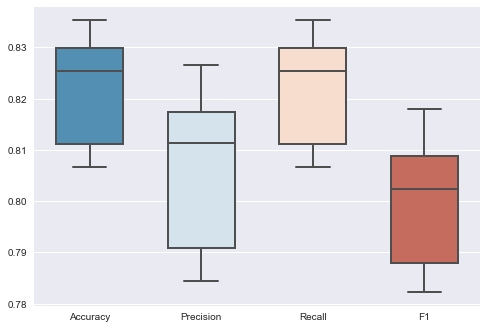

In [ ]:
#Free form visualization of all metrics of Gradient boosting(final model) and Log_regression(benchmark model)
import seaborn as sns
all_scores=[]
all_scores.append(scores)
all_scores.append(scores2)
all_scores.append(scores3)
all_scores.append(scores1)
eval1=[]
eval1.append('Accuracy')
eval1.append('Precision')
eval1.append('Recall')
eval1.append('F1')
ax=sns.boxplot(y=all_scores,x=eval1,palette=("RdBu_r"),linewidth=2.0,width=0.6)
#ax.set(ylim=(0.76, 0.82))